In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.io as pio
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
import webbrowser
import os

nltk.download('vader_lexicon')

apps_df=pd.read_csv('Play Store Data.csv')
reviews_df=pd.read_csv('User Reviews.csv')

#Step 2 : Data Cleaning
apps_df = apps_df.dropna(subset=['Rating'])
for column in apps_df.columns :
    apps_df[column].fillna(apps_df[column].mode()[0],inplace=True)
apps_df.drop_duplicates(inplace=True)
apps_df=apps_df=apps_df[apps_df['Rating']<=5]
reviews_df.dropna(subset=['Translated_Review'],inplace=True)

#Convert the Installs columns to numeric by removing commas and +
apps_df['Installs']=apps_df['Installs'].str.replace(',','').str.replace('+','').astype(int)

#Convert Price column to numeric after removing $
apps_df['Price']=apps_df['Price'].str.replace('$','').astype(float)

merged_df=pd.merge(apps_df,reviews_df,on='App',how='inner')

def convert_size(size):
    if 'M' in size:
        return float(size.replace('M',''))
    elif 'k' in size:
        return float(size.replace('k',''))/1024
    else:
        return np.nan
apps_df['Size']=apps_df['Size'].apply(convert_size)

#Lograrithmic
apps_df['Log_Installs']=np.log(apps_df['Installs'])

apps_df['Reviews']=apps_df['Reviews'].astype(int)

apps_df['Log_Reviews']=np.log(apps_df['Reviews'])

def rating_group(rating):
    if rating >= 4:
        return 'Top rated app'
    elif rating >=3:
        return 'Above average'
    elif rating >=2:
        return 'Average'
    else:
        return 'Below Average'
apps_df['Rating_Group']=apps_df['Rating'].apply(rating_group)

#Revenue column
apps_df['Revenue']=apps_df['Price']*apps_df['Installs']

sia = SentimentIntensityAnalyzer()

#Polarity Scores in SIA
#Positive, Negative, Neutral and Compound: -1 - Very negative ; +1 - Very positive

review = "This app is amazing! I love the new features."
sentiment_score= sia.polarity_scores(review)
print(sentiment_score)

review = "This app is very bad! I hate the new features."
sentiment_score= sia.polarity_scores(review)
print(sentiment_score)

review = "This app is okay."
sentiment_score= sia.polarity_scores(review)
print(sentiment_score)

reviews_df['Sentiment_Score']=reviews_df['Translated_Review'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

apps_df['Last Updated']=pd.to_datetime(apps_df['Last Updated'],errors='coerce')

apps_df['Year']=apps_df['Last Updated'].dt.year

html_files_path="./"
if not os.path.exists(html_files_path):
    os.makedirs(html_files_path)

plot_containers=""

# Save each Plotly figure to an HTML file
def save_plot_as_html(fig, filename, insight):
    global plot_containers
    filepath = os.path.join(html_files_path, filename)
    html_content = pio.to_html(fig, full_html=False, include_plotlyjs='inline')
    # Append the plot and its insight to plot_containers
    plot_containers += f"""
    <div class="plot-container" id="{filename}" onclick="openPlot('{filename}')">
        <div class="plot">{html_content}</div>
        <div class="insights">{insight}</div>
    </div>
    """
    fig.write_html(filepath, full_html=False, include_plotlyjs='inline')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Parkavi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Parkavi\AppData\Local\Temp\ipykernel_3136\701767692.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  apps_df[column].fillna(apps_df[column].mode()[0],inplace=True)


{'neg': 0.0, 'neu': 0.42, 'pos': 0.58, 'compound': 0.8516}
{'neg': 0.535, 'neu': 0.465, 'pos': 0.0, 'compound': -0.8427}
{'neg': 0.0, 'neu': 0.612, 'pos': 0.388, 'compound': 0.2263}


In [16]:
import pandas as pd
import pytz
from datetime import datetime, time
import plotly.graph_objects as go
import plotly.io as pio

apps_df = pd.read_csv("Play Store Data.csv")
apps_df['Last Updated'] = pd.to_datetime(apps_df['Last Updated'], errors='coerce')

apps_df['Reviews'] = pd.to_numeric(apps_df['Reviews'], errors='coerce')
apps_df['Installs'] = (
    apps_df['Installs']
    .astype(str)
    .str.replace(r'\D', '', regex=True)
    .replace('', '0')   # ⭐ ADD THIS LINE
    .astype(float)
)


apps_df['Size'] = (
    apps_df['Size']
    .astype(str)                         # 🔑 force to string
    .replace('Varies with device', None)
    .str.replace('M','', regex=False)
    .str.replace('k','', regex=False)
)


apps_df['Size'] = pd.to_numeric(apps_df['Size'], errors='coerce')


# ----------------------------
# TIME CHECK (3 PM – 5 PM IST)
# ----------------------------
def is_time_allowed():
    ist = pytz.timezone("Asia/Kolkata")
    now = datetime.now(ist).time()
    return time(15, 0) <= now <= time(17, 0)

# ----------------------------
# TASK 1 – FILTERED DATA
# (trainer-cleaned apps_df)
# ----------------------------
task1_df = apps_df[
    (apps_df['Rating'] >= 4.0) &            # Avg rating >= 4.0
    (apps_df['Size'] >= 10) &               # Size >= 10 MB
    (apps_df['Last Updated'].dt.month == 1) # January only
]

# ----------------------------
# TOP 10 CATEGORIES BY INSTALLS
# ----------------------------
category_summary = (
    task1_df
    .groupby('Category')
    .agg(
        avg_rating=('Rating', 'mean'),
        total_reviews=('Reviews', 'sum'),
        total_installs=('Installs', 'sum')
    )
    .sort_values('total_installs', ascending=False)
    .head(10)
    .reset_index()
)

# ----------------------------
# FIX CATEGORY LABEL OVERLAP
# ----------------------------
category_summary['Category'] = (
    category_summary['Category']
    .str.replace('_AND_', '<br>', regex=False)
    .str.replace('_', '<br>', regex=False)
)

# ----------------------------
# PLOT (ONLY IF TIME ALLOWED)
# ----------------------------
if is_time_allowed():

    fig = go.Figure()

    # Average Rating (Left Axis)
    fig.add_bar(
        x=category_summary['Category'],
        y=category_summary['avg_rating'],
        name='Average Rating',
        marker_color='#2E7D32',
        offsetgroup=0,
        width=0.35
    )

    # Total Reviews (Right Axis)
    fig.add_bar(
        x=category_summary['Category'],
        y=category_summary['total_reviews'],
        name='Total Reviews',
        marker_color='#EF6C00',
        yaxis='y2',
        offsetgroup=1,
        width=0.35
    )

    fig.update_layout(
        title=dict(
            text="<b>Grouped Comparison of Average Rating and Total Reviews</b>",
            x=0.5,
            font=dict(size=18)
        ),
        xaxis=dict(
            title="App Category",
            tickangle=-90,
            tickfont=dict(size=11),
            automargin=True
        ),
        yaxis=dict(
            title="Average Rating",
            range=[0, 5]
        ),
        yaxis2=dict(
            title="Total Reviews",
            overlaying='y',
            side='right',
            showgrid=False
        ),
        barmode='group',
        template='plotly_white',

        # ✅ METRICS BOX POSITION (M AREA)
        legend=dict(
            title="Metrics",
            orientation="h",
            x=0.5,
            y=0.96,
            xanchor="center",
            yanchor="bottom"
        ),

        height=420
    )

    fig.show()
    pio.write_html(fig, "task1.html", auto_open=False)

else:
    with open("task1.html", "w", encoding="utf-8") as f:
        f.write("""
        <html>
        <head>
            <style>
                body{
                    margin:0;
                    display:flex;
                    align-items:center;
                    justify-content:center;
                    height:100vh;
                    font-family:Segoe UI, Arial;
                    background:#f4f6f8;
                    color:#333;
                }
                .msg{
                    padding:30px 40px;
                    border-radius:16px;
                    background:white;
                    box-shadow:0 10px 25px rgba(0,0,0,0.15);
                    text-align:center;
                }
                h2{margin:0 0 10px;}
            </style>
        </head>
        <body>
            <div class="msg">
                <h2>⏰ Task 1 Unavailable</h2>
                <p>Visible only between <b>3 PM – 5 PM IST</b></p>
            </div>
        </body>
        </html>
        """)

    print("⏰ Task-1 chart visible only between 3 PM and 5 PM IST.")

⏰ Task-1 chart visible only between 3 PM and 5 PM IST.


In [34]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta, timezone

# 1. Load the dataset (using the same dataframe from your work)
apps_df = pd.read_csv('Play Store Data.csv')

# 2. Cleaning & Column Preparation
# Clean Installs: Remove non-numeric chars
apps_df['Installs_Num'] = apps_df['Installs'].str.replace(r'\D', '', regex=True).replace('', '0').astype(int)

# Clean Price and Calculate Revenue
apps_df['Price_Num'] = (
    apps_df['Price']
    .astype(str)
    .str.replace(r'[^0-9.]', '', regex=True)
    .replace('', '0')
    .astype(float)
)

apps_df['Revenue'] = apps_df['Price_Num'] * apps_df['Installs_Num']

# Clean Size (Convert to MB)
def get_size_mb(size):
    size = str(size)
    if 'M' in size: return float(size.replace('M', ''))
    if 'k' in size: return float(size.replace('k', '')) / 1024
    return 0
apps_df['Size_MB'] = apps_df['Size'].apply(get_size_mb)

# Clean Android Version (Take first 3 chars like '4.1')
def get_android_ver(ver):
    try:
        ver = str(ver)
        if 'Varies' in ver or ver == 'nan': return 0.0
        return float(ver[:3])
    except: return 0.0
apps_df['Android_Ver_Num'] = apps_df['Android Ver'].apply(get_android_ver)

# App Name Length
apps_df['Name_Len'] = apps_df['App'].str.len()

# 3. Apply Filters
# Filters: Android > 4.0, Size > 15M, Content Rating 'Everyone', Name <= 30 chars
# Exclusion: Keep apps EXCEPT those that have BOTH (Installs < 10k AND Revenue < 10k)
filtered_df = apps_df[
    (apps_df['Android_Ver_Num'] > 4.0) &
    (apps_df['Size_MB'] > 15) &
    (apps_df['Content Rating'] == 'Everyone') &
    (apps_df['Name_Len'] <= 30) &
    ~((apps_df['Installs_Num'] < 10000) & (apps_df['Revenue'] < 10000))
].copy()

# 4. Identify Top 3 Categories (by Total Installs)
top_3_cats = filtered_df.groupby('Category')['Installs_Num'].sum().nlargest(3).index
task2_df = filtered_df[filtered_df['Category'].isin(top_3_cats)]

# Group data for Free vs Paid comparison
compare_df = task2_df.groupby(['Category', 'Type']).agg({
    'Installs_Num': 'mean',
    'Revenue': 'mean'
}).reset_index()

# 5. Time Check (1 PM to 2 PM IST)
now_ist = datetime.now(timezone(timedelta(hours=5, minutes=30)))

if 13 <= now_ist.hour< 14: # 13:00 to 13:59 is 1 PM to 2 PM IST
    
    # 6. Create Dual-Axis Chart
    fig = go.Figure()

    # Trace for Average Installs (Primary Y-axis)
    for t_type in ['Free', 'Paid']:
        subset = compare_df[compare_df['Type'] == t_type]
        fig.add_trace(go.Bar(
            x=subset['Category'],
            y=subset['Installs_Num'],
            name=f'{t_type} - Avg Installs',
            yaxis='y1',
            offsetgroup=t_type,
            marker_color="#0D47A1" if t_type=="Free" else "#EC407A"
        ))

    # Trace for Average Revenue (Secondary Y-axis)
    # We use a Scatter/Line trace for Revenue to keep it clear on the dual axis
    for t_type in ['Free', 'Paid']:
        subset = compare_df[compare_df['Type'] == t_type]
        fig.add_trace(go.Scatter(
            x=subset['Category'],
            y=subset['Revenue'],
            name=f'{t_type} - Avg Revenue ($)',
            yaxis='y2',
            mode='lines+markers',
            line=dict(color="#4DB6AC", width=3)if t_type=="Paid" else dict(color="#F9A825",width=2)
        ))

    # Layout for Dual Axis
    fig.update_layout(
        title=dict(
            text="<b>Free vs Paid Apps: Avg Installs & Revenue (Top 3 Categories)</b>",
            x=0.5,
            xanchor="center"
        ),
        xaxis_title="Category",
        yaxis=dict(title="Avg Installs", side="left"),
        yaxis2=dict(title="Avg Revenue ($)", side="right", overlaying="y"),
        barmode="group",
        template="plotly_white",
        legend=dict(
            title="Metrics",
            orientation="h",
            x=0.5,
            y=1.18,
            xanchor="center",
            yanchor="top"
        )

    )
    fig.update_layout(
        legend=dict(
            orientation="h",
            y=-0.40,
            x=0.5,
            xanchor="center",
            bgcolor="rgba(255,255,255,0.9)",
            bordercolor="black",
            borderwidth=1
        ),
        margin=dict(t=80, b=120)
    )

    fig.show()
    pio.write_html(fig, "task2.html", auto_open=False)

else:
    with open("task2.html", "w", encoding="utf-8") as f:
        f.write("""
        <html>
        <head>
            <style>
                body{
                    margin:0;
                    display:flex;
                    align-items:center;
                    justify-content:center;
                    height:100vh;
                    font-family:Segoe UI, Arial;
                    background:#f4f6f8;
                    color:#333;
                }
                .msg{
                    padding:30px 40px;
                    border-radius:16px;
                    background:white;
                    box-shadow:0 10px 25px rgba(0,0,0,0.15);
                    text-align:center;
                }
                h2{margin:0 0 10px;}
            </style>
        </head>
        <body>
            <div class="msg">
                <h2>⏰ Task 2 Unavailable</h2>
                <p>Visible only between <b>1 PM – 2 PM IST</b></p>
            </div>
        </body>
        </html>
        """)

    print(f"Task 2 graph is hidden. Currently IST: {now_ist.strftime('%H:%M')}. Visible only 1 PM - 2 PM.")

Task 2 graph is hidden. Currently IST: 16:47. Visible only 1 PM - 2 PM.


In [5]:
import pandas as pd
import plotly.express as px
from datetime import datetime, time
import pytz
import plotly.io as pio

# ----------------------------
# TIME CHECK (6 PM – 8 PM IST)
# ----------------------------
def is_ist_time_allowed():
    ist = pytz.timezone("Asia/Kolkata")
    now = datetime.now(ist).time()
    return time(18, 0) <= now <= time(20, 0)

# ----------------------------
# LOAD DATASET (TRAINER DATASET)
# ----------------------------
apps_df = pd.read_csv("Play Store Data.csv")

# ----------------------------
# DATA CLEANING
# ----------------------------
apps_df["Installs_Num"] = (
    apps_df["Installs"]
    .astype(str)
    .str.replace(r"\D", "", regex=True)
)
apps_df["Installs_Num"] = pd.to_numeric(apps_df["Installs_Num"], errors="coerce")

# ----------------------------
# CATEGORY FILTER
# (Category should NOT start with A, C, G, S)
# ----------------------------
apps_df = apps_df[
    ~apps_df["Category"].str.startswith(("A", "C", "G", "S"), na=False)
]

# ----------------------------
# TOP 5 CATEGORIES BY TOTAL INSTALLS
# ----------------------------
top_5_categories = (
    apps_df.groupby("Category")["Installs_Num"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

apps_df = apps_df[apps_df["Category"].isin(top_5_categories)]

# ----------------------------
# CREATE PSEUDO GLOBAL DATA
# (Because dataset has no country column)
# ----------------------------
country_mapping = {
    top_5_categories[0]: "USA",
    top_5_categories[1]: "IND",
    top_5_categories[2]: "GBR",
    top_5_categories[3]: "CAN",
    top_5_categories[4]: "AUS",
}

apps_df["Country"] = apps_df["Category"].map(country_mapping)

# ----------------------------
# AGGREGATION
# ----------------------------
map_df = (
    apps_df.groupby(["Country", "Category"])
    .agg(total_installs=("Installs_Num", "sum"))
    .reset_index()
)

map_df["Highlight"] = map_df["total_installs"] > 1_000_000


# ----------------------------
# PLOT (ONLY IF TIME IS VALID)
# ----------------------------
if is_ist_time_allowed():

    fig = px.choropleth(
        map_df,
        locations="Country",
        locationmode="ISO-3",
        color="total_installs",
        hover_name="Category",
        hover_data=["Highlight"],
        color_continuous_scale="Teal",
        labels={"total_installs": "Total Installs"},
        title="Global Installs by Top App Categories"
    )

    fig.update_layout(
        title=dict(
            text="<b>Global Installs by Top App Categories</b>",
            x=0.5,
            font=dict(size=20, color="#020617")
        ),
        paper_bgcolor="#f0faff",
        plot_bgcolor="#f0faff",
        
        geo=dict(
            bgcolor="#f0faff",
            showland=True,
            landcolor="#E6E6E6",
            showcountries=True,
            countrycolor="black",
            showocean=True,
            oceancolor="#D6EEF8",
            projection_type="natural earth"
        )

    )

    fig.show()
    pio.write_html(fig, "task3.html", auto_open=False)

else:
    with open("task3.html", "w", encoding="utf-8") as f:
        f.write("""
        <html>
        <head>
            <style>
                body{
                    margin:0;
                    display:flex;
                    align-items:center;
                    justify-content:center;
                    height:100vh;
                    font-family:Segoe UI, Arial;
                    background:#f4f6f8;
                    color:#333;
                }
                .msg{
                    padding:30px 40px;
                    border-radius:16px;
                    background:white;
                    box-shadow:0 10px 25px rgba(0,0,0,0.15);
                    text-align:center;
                }
                h2{margin:0 0 10px;}
            </style>
        </head>
        <body>
            <div class="msg">
                <h2>⏰ Task 3 Unavailable</h2>
                <p>Visible only between <b>6 PM – 8 PM IST</b></p>
            </div>
        </body>
        </html>
        """)

    print("⏰ Task-3 map visible only between 6 PM and 8 PM IST.")


⏰ Task-3 map visible only between 6 PM and 8 PM IST.


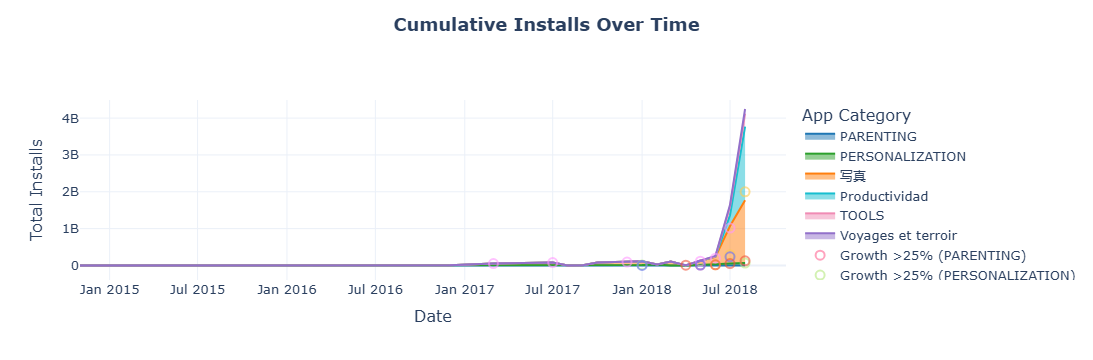

In [6]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta, timezone

df = pd.read_csv("Play Store Data.csv")

df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Installs'] = df['Installs'].astype(str).str.replace(r'\D', '', regex=True).replace('', '0').astype(int)
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
df['Last Updated'] = pd.to_datetime(df['Last Updated'], errors='coerce')

def clean_size(size):
    size_str = str(size)
    if 'M' in size_str: return float(size_str.replace('M', ''))
    if 'k' in size_str: return float(size_str.replace('k', '')) / 1024
    return 0
df['Size_MB'] = df['Size'].apply(clean_size)

mask = (
    (df['Rating'] >= 4.2) &
    (~df['App'].str.contains(r'\d', na=False)) &
    (df['Category'].str.startswith(('T', 'P'), na=False)) &
    (df['Reviews'] > 1000) &
    (df['Size_MB'] >= 20) & (df['Size_MB'] <= 80)
)

df_filtered = df[mask].copy()

now_utc = datetime.now(timezone.utc)
now_ist = now_utc + timedelta(hours=5, minutes=30)
current_hour = now_ist.hour

if 16 <= current_hour < 18:
    # Prepare Time Series Data (Cumulative Installs)
    df_filtered['Month_Year'] = df_filtered['Last Updated'].dt.to_period('M').dt.to_timestamp()
    
    # Group by Category and Month
    ts_df = df_filtered.groupby(['Category', 'Month_Year'])['Installs'].sum().reset_index()
    ts_df = ts_df.sort_values(['Category', 'Month_Year'])
    
    # Calculate Cumulative Installs and MoM Growth
    ts_df['Cumulative_Installs'] = ts_df.groupby('Category')['Installs'].cumsum()
    ts_df['MoM_Growth'] = ts_df.groupby('Category')['Installs'].pct_change()

    # Translation Mapping for Legend
    translations = {
        'TRAVEL_AND_LOCAL': 'Voyages et terroir',
        'PRODUCTIVITY': 'Productividad',
        'PHOTOGRAPHY': '写真'
    }
    ts_df['Category_Display'] = ts_df['Category'].map(lambda x: translations.get(x, x))

    # 4. Create Stacked Area Chart
    fig = px.area(
        ts_df,
        x='Month_Year',
        y='Cumulative_Installs',
        color='Category_Display',
        color_discrete_sequence=[
            "#1F77B4",  # blue
            "#2CA02C",  # green
            "#FF7F0E",  # yellow
            "#17BECF",  # coral
            "#F08BB4 ",
            "#9270CA" #purple
        ],
        title='<b>Task 4: Cumulative Installs Over Time (4 PM - 6 PM IST Only)</b>', 
        labels={'Month_Year': 'Date', 'Cumulative_Installs': 'Total Installs', 'Category_Display': 'Legend'}
    )
    for trace in fig.data:
        trace.opacity = 0.6   # base opacity



    # 5. Highlight MoM Increase > 25%
    high_growth = ts_df[ts_df['MoM_Growth'] > 0.25]



    for cat in high_growth['Category_Display'].unique():

        cat_data = high_growth[high_growth['Category_Display'] == cat]

        fig.add_trace(go.Scatter(

            x=cat_data['Month_Year'],

            y=cat_data['Cumulative_Installs'],

            mode='markers',

            marker=dict(size=9, symbol='circle-open',opacity=0.6, line=dict(width=2, color='#D62728')),

            name=f'Growth >25% ({cat})',

            hoverinfo='text',

            text=[f"{cat}: {g:.1%} MoM Increase" for g in cat_data['MoM_Growth']]

        ))

    # Increase color intensity for high-growth months (area emphasis)
    fig.add_trace(
        go.Scatter(
            x=high_growth['Month_Year'],
            y=high_growth['Cumulative_Installs'],
            mode='lines',
            line=dict(width=0),
            fill='tonexty',
            fillcolor='rgba(255,0,0,0.25)',  # increased intensity
            showlegend=False,
            hoverinfo='skip'
        )
    )

    
    fig.update_layout(
        template="plotly_white",
        title_x=0.5,
        font=dict(size=13),
        legend_title="App Category"
    )
    fig.update_layout(
        title=dict(
            text="<b>Cumulative Installs Over Time</b>",
            x=0.5,
            y=0.95
        ),
        margin=dict(t=100)
    )

    fig.show()
    import plotly.io as pio
    pio.write_html(fig, "task4.html", auto_open=False)
    fig4 = fig
else:
    with open("task4.html", "w", encoding="utf-8") as f:
        f.write("""
        <html>
        <head>
            <style>
                body{
                    margin:0;
                    display:flex;
                    align-items:center;
                    justify-content:center;
                    height:100vh;
                    font-family:Segoe UI, Arial;
                    background:#f4f6f8;
                    color:#333;
                }
                .msg{
                    padding:30px 40px;
                    border-radius:16px;
                    background:white;
                    box-shadow:0 10px 25px rgba(0,0,0,0.15);
                    text-align:center;
                }
                h2{margin:0 0 10px;}
            </style>
        </head>
        <body>
            <div class="msg">
                <h2>⏰ Task 4 Unavailable</h2>
                <p>Visible only between <b>4 PM – 6 PM IST</b></p>
            </div>
        </body>
        </html>
        """)

    print(f"Task 4 is currently hidden. Current IST: {now_ist.strftime('%H:%M')}. Please check back between 4 PM and 6 PM IST.")

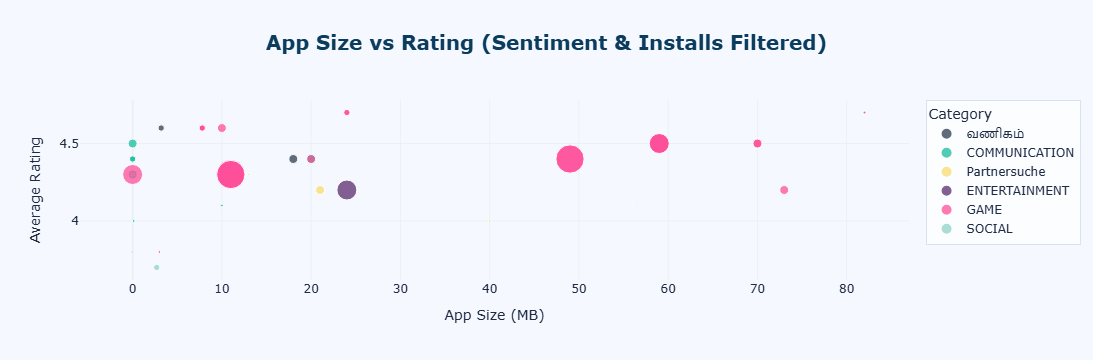

In [7]:
import pandas as pd
import plotly.express as px
from datetime import datetime, timedelta, timezone

apps_df = pd.read_csv("Play Store Data.csv")
reviews_df=pd.read_csv('User Reviews.csv')

sentiment_avg = reviews_df.groupby('App')['Sentiment_Subjectivity'].mean().reset_index()

df = pd.merge(apps_df, sentiment_avg, on='App')

df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')
# Clean Installs
df['Installs_Num'] = pd.to_numeric(df['Installs'].astype(str).str.replace(r'\D', '', regex=True), errors='coerce').fillna(0)

def clean_size(size):
    size_str = str(size)
    if 'M' in size_str: return float(size_str.replace('M', ''))
    if 'k' in size_str: return float(size_str.replace('k', '')) / 1024
    return 0
df['Size_MB'] = df['Size'].apply(clean_size)

now_ist = datetime.now(timezone(timedelta(hours=5, minutes=30)))
current_hour = now_ist.hour

if 17 <= current_hour < 19:
    # 5. Apply Filters
    # - Rating > 3.5
    # - Specific Categories
    # - Reviews > 500
    # - Name does NOT contain 'S' (case-insensitive)
    # - Subjectivity > 0.5
    # - Installs > 50,000
    
    target_cats = ['GAME', 'BEAUTY', 'BUSINESS', 'COMICS', 'COMMUNICATION', 'DATING', 'ENTERTAINMENT', 'SOCIAL', 'EVENTS']
    
    mask = (
        (df['Category'].str.upper().isin(target_cats)) &
        (df['Rating'] > 3.5) &
        (df['Reviews'] > 500) &
        (~df['App'].str.contains('S', case=False, na=False)) &
        (df['Sentiment_Subjectivity'] > 0.5) &
        (df['Installs_Num'] > 50000)
    )
    filtered_df = df[mask].copy()

    # 6. Translations
    # Beauty -> Hindi, Business -> Tamil, Dating -> German
    translation_map = {
        'BEAUTY': 'सुंदरता',
        'BUSINESS': 'வணிகம்',
        'DATING': 'Partnersuche' # German for Dating/Partner search
    }
    filtered_df['Category_Display'] = filtered_df['Category'].str.upper().map(lambda x: translation_map.get(x, x))

    # 7. Create Bubble Chart
    fig = px.scatter(
        filtered_df,
        x='Size_MB',
        y='Rating',
        size='Installs_Num',
        color='Category_Display',

        color_discrete_map = {
            'GAME': '#ff4f9a',          # pink
            'COMMUNICATION': '#1abc9c', # dark blue
            'ENTERTAINMENT': '#5b2c6f', # dark purple
            'SOCIAL': '#8fd3c7',        # teal
            'வணிகம்': '#2c3e50',       # 🔥 DARK NAVY (Business / Vanigam)
            'सुंदरता': '#c39bd3',
            'Partnersuche': '#f7dc6f'
        },


        # Highlight GAME category in Pink
        
        title="<b>App Size vs Rating (Sentiment & Installs Filtered)</b>",
        labels={
            'Size_MB': 'App Size (MB)', 
            'Rating': 'Average Rating', 
            'Category_Display': 'Category',
            'Installs_Num': 'Total Installs'
        },
        hover_name='App'
    )

    fig.update_layout(
        template="plotly_white",
        plot_bgcolor="#f5f9ff",
        paper_bgcolor="#f5f9ff",
        title_font=dict(size=20, color="#0b3c5d"),
        font=dict(color="#1f2a44"),
        title_x=0.5
    )

    fig.update_traces(
        marker=dict(
            opacity=0.75,
            line=dict(width=1, color="white")
        )
    )

    fig.update_layout(
        legend=dict(
            title="Category",
            bgcolor="rgba(255,255,255,0.6)",
            bordercolor="#d6e4f0",
            borderwidth=1
        )
    )

    fig.update_layout(title_x=0.5)
    fig.show()
    import plotly.io as pio
    pio.write_html(fig, "task5.html", auto_open=False)
    fig5 = fig
else:
    with open("task5.html", "w", encoding="utf-8") as f:
        f.write("""
        <html>
        <head>
            <style>
                body{
                    margin:0;
                    display:flex;
                    align-items:center;
                    justify-content:center;
                    height:100vh;
                    font-family:Segoe UI, Arial;
                    background:#f4f6f8;
                    color:#333;
                }
                .msg{
                    padding:30px 40px;
                    border-radius:16px;
                    background:white;
                    box-shadow:0 10px 25px rgba(0,0,0,0.15);
                    text-align:center;
                }
                h2{margin:0 0 10px;}
            </style>
        </head>
        <body>
            <div class="msg">
                <h2>⏰ Task 5 Unavailable</h2>
                <p>Visible only between <b>5 PM – 7 PM IST</b></p>
            </div>
        </body>
        </html>
        """)

    print(f"Task 5 hidden. Current IST: {now_ist.strftime('%H:%M')}. (Visible 5PM-7PM)")

In [8]:
import pandas as pd
import plotly.graph_objects as go
from datetime import datetime, timedelta, timezone

# -----------------------------
# LOAD DATA
# -----------------------------
df = pd.read_csv("Play Store Data.csv")

# -----------------------------
# DATA CLEANING
# -----------------------------
df["Installs"] = (
    df["Installs"]
    .astype(str)
    .str.replace(r"\D", "", regex=True)
)
df["Installs"] = pd.to_numeric(df["Installs"], errors="coerce").fillna(0)

df["Reviews"] = pd.to_numeric(df["Reviews"], errors="coerce").fillna(0)
df["Last Updated"] = pd.to_datetime(df["Last Updated"], errors="coerce")

# -----------------------------
# FILTER CONDITIONS (EXACT)
# -----------------------------
mask = (
    (df["Category"].str.startswith(("E", "C", "B"), na=False)) &
    (~df["App"].str.startswith(("X", "Y", "Z", "x", "y", "z"), na=False)) &
    (~df["App"].str.contains("S", case=False, na=False)) &
    (df["Reviews"] > 500)
)

df = df[mask].copy()

# -----------------------------
# CATEGORY TRANSLATION (DISPLAY ONLY)
# -----------------------------
translation_map = {
    "BEAUTY": "सुंदरता",       # Hindi
    "BUSINESS": "வணிகம்",     # Tamil
    "DATING": "Partnersuche"    # German
}
df["Category_Display"] = df["Category"].replace(translation_map)

# -----------------------------
# TIME GATE (6 PM – 9 PM IST)
# -----------------------------
now_ist = datetime.now(timezone.utc) + timedelta(hours=5, minutes=30)
current_hour = now_ist.hour

if 18 <= current_hour < 21:

    # -----------------------------
    # TIME SERIES PREP
    # -----------------------------
    df["Month"] = df["Last Updated"].dt.to_period("M").dt.to_timestamp()

    ts = (
        df.groupby(["Category_Display", "Month"])["Installs"]
        .sum()
        .reset_index()
        .sort_values(["Category_Display", "Month"])
    )

    ts["MoM_Growth"] = ts.groupby("Category_Display")["Installs"].pct_change()

    # -----------------------------
    # PLOT
    # -----------------------------
    fig = go.Figure()

    for cat in ts["Category_Display"].unique():
        cat_df = ts[ts["Category_Display"] == cat]

        # Line
        fig.add_trace(
            go.Scatter(
                x=cat_df["Month"],
                y=cat_df["Installs"],
                mode="lines",
                name=cat,
                line=dict(width=2)
            )
        )

        # Shade ONLY where growth > 20%
        growth_df = cat_df[cat_df["MoM_Growth"] > 0.20]
        if not growth_df.empty:
            fig.add_trace(
                go.Scatter(
                    x=growth_df["Month"],
                    y=growth_df["Installs"],
                    mode="markers",
                    marker=dict(
                        size=10,
                        color="red",
                        symbol="circle"
                    ),
                    name=">20% Growth",
                    showlegend=False
                )
            )


        for _, row in growth_df.iterrows():
            prev_row = cat_df[cat_df["Month"] < row["Month"]].tail(1)
        
            if not prev_row.empty:
                fig.add_vrect(
                    x0=prev_row["Month"].values[0],
                    x1=row["Month"],
                    fillcolor="rgba(255,0,0,0.35)",  # light highlight
                    
                    layer="below",
                    line_width=0
                )

    # -----------------------------
    # LAYOUT POLISH
    # -----------------------------
    fig.update_layout(
        title="<b>Trend of Total Installs Over Time <br>(Filtered & Translated Categories)</b>",
        xaxis_title="Date",
        yaxis_title="Total Installs",
        template="plotly_white",
        hovermode="x unified",
        title_x=0.5
    )

    fig.update_yaxes(type="log")  # improves readability

    fig.update_traces(
        selector=dict(name="COMICS"),
        line=dict(color="#1f77b4")   # blue
    )
    fig.update_traces(
        selector=dict(name="ENTERTAINMENT"),
        line=dict(color="#2E7D32")   # orange
    )

    fig.update_traces(
        selector=dict(name="COMMUNICATION"),
        line=dict(color="#ff4f9a")   # pink
    )
    
    fig.update_traces(
        selector=dict(name="வணிகம்"),
        line=dict(color="#FF9800")   # red
    )
    
    fig.update_traces(
        selector=dict(name="EVENTS"),
        line=dict(color="#fbc02d")   # yellow
    )


    fig.show()
    import plotly.io as pio
    pio.write_html(fig, "task6.html", auto_open=False)
    fig6 = fig

else:
    with open("task6.html", "w", encoding="utf-8") as f:
        f.write("""
        <html>
        <head>
            <style>
                body{
                    margin:0;
                    display:flex;
                    align-items:center;
                    justify-content:center;
                    height:100vh;
                    font-family:Segoe UI, Arial;
                    background:#f4f6f8;
                    color:#333;
                }
                .msg{
                    padding:30px 40px;
                    border-radius:16px;
                    background:white;
                    box-shadow:0 10px 25px rgba(0,0,0,0.15);
                    text-align:center;
                }
                h2{margin:0 0 10px;}
            </style>
        </head>
        <body>
            <div class="msg">
                <h2>⏰ Task 6 Unavailable</h2>
                <p>Visible only between <b>6 PM – 9 PM IST</b></p>
            </div>
        </body>
        </html>
        """)

    print("⏰ This chart is visible only between 6 PM and 9 PM IST.")


⏰ This chart is visible only between 6 PM and 9 PM IST.


In [15]:
import os, webbrowser

dashboard_html = """
<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="UTF-8">
<title>Google Play Store Reviews Analytics</title>

<style>
body{
    margin:0;
    font-family:"Segoe UI", Arial, sans-serif;
    background: linear-gradient(135deg,#0f2027,#203a43,#2c5364);
    color:white;
}

/* Force Plotly legend to bottom in modal */
.modal iframe html,
.modal iframe body {
    height: auto !important;
}


/* ================= HEADER ================= */
.header{
    position:fixed;
    top:0;
    left:0;
    width:100%;
    height:70px;
    z-index:1000;
    background: linear-gradient(90deg,#0b0f14,#1f2f3f);
    box-shadow:0 6px 20px rgba(0,0,0,0.6);
}

.header-inner{
    max-width:1400px;
    margin:0 auto;
    height:100%;
    display:flex;
    align-items:center;
    justify-content:center;
    position:relative;
}

/* Title */
.title{
    font-size:28px;
    font-weight:600;
    text-align:center;
}

/* Google colored letters */
.title span:nth-child(1){color:#4285F4;}
.title span:nth-child(2){color:#EA4335;}
.title span:nth-child(3){color:#FBBC05;}
.title span:nth-child(4){color:#34A853;}

/* Play Store logo */
.play{
    position:absolute;
    right:20px;
}
.play img{
    height:36px;
}

/* ================= CONTENT ================= */
.container{
    padding:120px 30px 40px;
    display:grid;
    grid-template-columns:repeat(2,1fr);
    gap:28px;
}

/* ================= CARDS ================= */
.card{
    padding:18px;
    border-radius:22px;
    box-shadow:0 16px 32px rgba(0,0,0,0.45);
    transition:box-shadow 0.3s ease, filter 0.3s ease;
}
.card:hover{
    filter:brightness(1.05);
}

/* Gradients */
/* Task 1 – Green / Orange (Ratings & Reviews) */
.t1 {
  background: linear-gradient(135deg, #1b5e20, #ef6c00);
}

/* Task 2 – Blue / Pink (Category Analysis) */
.t2 {
  background: linear-gradient(135deg, #0d47a1, #ad1457);
}

/* Task 3 – Teal / Blue (Sentiment) */
.t3 {
  background: linear-gradient(135deg, #006064, #1565c0);
}

/* Task 4 – Dark Slate / Green (Installs) */
.t4 {
  background: linear-gradient(135deg, #263238, #2e7d32);
}

/* Task 5 – Charcoal / Silver (Bubble Chart) */
.t5 {
  background: linear-gradient(135deg, #212121, #616161);
}

/* Task 6 – Indigo / Cyan (Time Series) */
.t6 {
  background: linear-gradient(135deg, #283593, #00838f);
}



/* Glow */
.t1:hover{ box-shadow: 0 0 28px rgba(180,150,60,0.55); }
.t2:hover{ box-shadow: 0 0 28px rgba(60,100,200,0.55); }
.t3:hover{ box-shadow: 0 0 28px rgba(120,70,180,0.55); }
.t4:hover{ box-shadow: 0 0 28px rgba(70,150,160,0.55); }
.t5:hover{ box-shadow: 0 0 26px rgba(200,200,200,0.55); }
.t6:hover{ box-shadow: 0 0 28px rgba(80,170,220,0.55); }

.card h2{
    text-align:center;
    margin-bottom:12px;
    font-size:20px;
    font-weight:600;
}

/* ===== MODAL OVERLAY ===== */
.modal {
    display: none;
    position: fixed;
    z-index: 2000;
    left: 0;
    top: 0;
    width: 100%;
    height: 100%;
    background: rgba(0,0,0,0.85);
}

.modal-content {
    position: relative;
    width: 90%;
    height: 90%;
    margin: 3% auto;
    background: #fff;
    border-radius: 20px;
    padding: 10px;
}

.modal iframe {
    width: 100%;
    height: 100%;
    border-radius: 16px;
    overflow: auto;
}

/* Close button */
.close-btn {
    position: absolute;
    top: 10px;
    right: 18px;
    font-size: 26px;
    font-weight: bold;
    cursor: pointer;
    color: black;
}


/* ================= IFRAME ================= */
iframe{
    width:100%;
    height:420px;
    border:none;
    border-radius:16px;
    background:white;
}

.card{
    position: relative;
}

.click-overlay{
    position: absolute;
    top: 0;
    left: 0;
    width: 100%;
    height: 100%;
    cursor: pointer;
    z-index: 5;
}

.card iframe{
    pointer-events: none;
}

.expand-text{
    text-align: center;
    font-size: 13px;
    opacity: 0.8;
    margin-top: -8px;
    margin-bottom: 6px;
    letter-spacing: 0.4px;
}

</style>
</head>

<body>

<!-- HEADER -->
<div class="header">
    <div class="header-inner">
        <div class="title">
            <span>G</span><span>o</span><span>o</span><span>g</span><span>l</span><span>e</span>
            Google Play Store Reviews Analytics
        </div>
        <div class="play">
            <img src="https://upload.wikimedia.org/wikipedia/commons/7/78/Google_Play_Store_badge_EN.svg">
        </div>
    </div>
</div>

<!-- DASHBOARD -->
<div class="container">

<div class="card t1" onclick="openModal('task1.html')">
    <h2>Task 1 – Ratings vs Reviews</h2>
    <p class="expand-text">Click to expand</p>
    <iframe src="task1.html"></iframe>
</div>

<div class="card t2" onclick="openModal('task2.html')">
    <h2>Task 2 – Category Analysis</h2>
    <p class="expand-text">Click to expand</p>
    <iframe class="task2-frame" src="task2.html" onclick="openModal('task2.html')"></iframe>
</div>

<div class="card t3" onclick="openModal('task3.html')">
    <h2>Task 3 – Sentiment Insights</h2>
    <p class="expand-text">Click to expand</p>
    <iframe src="task3.html"></iframe>
</div>

<div class="card t4" onclick="openModal('task4.html')">
    <h2>Task 4 – Installs Distribution</h2>
    <p class="expand-text">Click to expand</p>
    <iframe src="task4.html"></iframe>
</div>

<div class="card t5" onclick="openModal('task5.html')">
    <h2>Task 5 – Bubble Chart</h2>
    <p class="expand-text">Click to expand</p>
    <iframe src="task5.html"></iframe>
</div>

<div class="card t6" onclick="openModal('task6.html')">
    <h2>Task 6 – Time Series Trend</h2>
    <p class="expand-text">Click to expand</p>
    <iframe src="task6.html"></iframe>
</div>


</div>

<!-- MODAL -->
<div id="modal" class="modal" onclick="closeModal()" tabindex="-1">
    <div class="modal-content" onclick="event.stopPropagation()">
        <span class="close-btn" onclick="closeModal()">✖</span>
        <iframe id="modalFrame"></iframe>
    </div>
</div>

<script>
function openModal(src){
    const modal = document.getElementById("modal");
    const frame = document.getElementById("modalFrame");

    frame.src = src;
    modal.style.display = "block";
    modal.focus();
}

function closeModal(){
    const modal = document.getElementById("modal");
    const frame = document.getElementById("modalFrame");

    modal.style.display = "none";
    frame.src = "";   // prevents blinking
}


document.addEventListener("keydown", function(event){
    if(event.key === "Escape"){
        closeModal();
    }
});

/* 🔒 Force focus back to modal when iframe steals it */
const modal = document.getElementById("modal");
const modalFrame = document.getElementById("modalFrame");

/* When iframe is clicked, refocus modal */
modalFrame.addEventListener("load", () => {
    modalFrame.contentWindow.addEventListener(
        "mousedown",
        () => modal.focus(),
        true
    );

    modalFrame.contentWindow.addEventListener(
        "keydown",
        (e) => {
            if (e.key === "Escape") {
                closeModal();
            }
        },
        true
    );
});

</script>

</body>
</html>
"""

dashboard_path = "dashboard.html"
with open(dashboard_path,"w",encoding="utf-8") as f:
    f.write(dashboard_html)

webbrowser.open("file://" + os.path.abspath(dashboard_path))


True